In [1]:
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme='gruvboxd',context='notebook')
import tensorflow as tf
import tensorflow.keras.layers as tfl
import numpy as np
import sklearn.metrics

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Num GPUs Available:  1
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5



In [3]:
data_dir = "C:/Users/R3M0/Documents/Project KLE-BGM/Models/SN"
batch_size=8
img_height=1080
img_width=1080
img_size=(img_height,img_width)

In [4]:
train=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    validation_split=0.2,
    subset='training',
    seed=22,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 227 files belonging to 2 classes.
Using 182 files for training.


In [5]:
validation=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    validation_split=0.2,
    subset='validation',
    seed=22,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 227 files belonging to 2 classes.
Using 45 files for validation.


In [6]:
# class_names=train.class_names
# print(class_names)

In [7]:
# plt.figure(figsize=(10,10))
# for images,labels in train.take(1):
#     for i in range(16):
#         ax=plt.subplot(4,4,i+1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(class_names[labels[i]])
#         plt.axis("off")
# plt.show()

In [8]:
for image,labels in train:
    print(image.shape)
    print(labels.shape)
    break

(8, 1080, 1080, 3)
(8,)


In [9]:
Autotune=tf.data.experimental.AUTOTUNE
train=train.prefetch(buffer_size=Autotune)

In [10]:
# data augmentation
data_aug=tf.keras.Sequential([
    tfl.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tfl.experimental.preprocessing.RandomRotation((-0.2,0.2)),
    tfl.experimental.preprocessing.RandomZoom(height_factor=(0.05,0.2),width_factor=(0.05,0.2)) 
])

In [11]:
##visualize data augmentation
# for image,_ in train.take(1):
#     plt.figure(figsize=(10,10))
#     first_img=image[0]
#     for i in range(16):
#         ax=plt.subplot(4,4,i+1)
#         aug_img=data_aug(tf.expand_dims(first_img,0))
#         plt.imshow(aug_img[0]/255)
#         plt.axis("off")
# plt.show()

In [12]:
model=tf.keras.Sequential([
    tfl.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height,img_width,3)),
    data_aug,
    tfl.Conv2D(16,12,strides=4,padding='valid',activation='relu'),
    tfl.BatchNormalization(axis=3),
    tfl.MaxPool2D(),
    tfl.Conv2D(32,5,strides=2,padding='valid',activation='relu'),
    tfl.BatchNormalization(axis=3),
    tfl.MaxPool2D(),
    tfl.Dropout(0.05),
    tfl.Conv2D(64,5,strides=2,padding='valid',activation='relu'),
    tfl.BatchNormalization(axis=3),
    tfl.MaxPool2D(),
    tfl.Dropout(0.15),
    tfl.Flatten(),
    tfl.Dense(32, activation='relu'),
    tfl.Dense(1,activation='sigmoid'),
])

In [13]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 1080, 1080, 3)     0         
_________________________________________________________________
sequential (Sequential)      (None, 1080, 1080, 3)     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 268, 268, 16)      6928      
_________________________________________________________________
batch_normalization (BatchNo (None, 268, 268, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 134, 134, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 65, 65, 32)        12832     
_________________________________________________________________
batch_normalization_1 (Batch (None, 65, 65, 32)       

In [15]:
epochs=5
history=model.fit(
    train,
    validation_data=validation,
    epochs=epochs
)

Epoch 1/5
23/23 [==============================] - 8s 175ms/step - loss: 0.3809 - accuracy: 0.8736 - val_loss: 1.7565 - val_accuracy: 0.7111
Epoch 2/5
23/23 [==============================] - 4s 159ms/step - loss: 0.2477 - accuracy: 0.8956 - val_loss: 4.6999 - val_accuracy: 0.7111
Epoch 3/5
23/23 [==============================] - 4s 161ms/step - loss: 0.2692 - accuracy: 0.9176 - val_loss: 2.0148 - val_accuracy: 0.7111
Epoch 4/5
23/23 [==============================] - 4s 155ms/step - loss: 0.2880 - accuracy: 0.8901 - val_loss: 0.7124 - val_accuracy: 0.7111
Epoch 5/5
23/23 [==============================] - 4s 158ms/step - loss: 0.1583 - accuracy: 0.9451 - val_loss: 1.3424 - val_accuracy: 0.7111


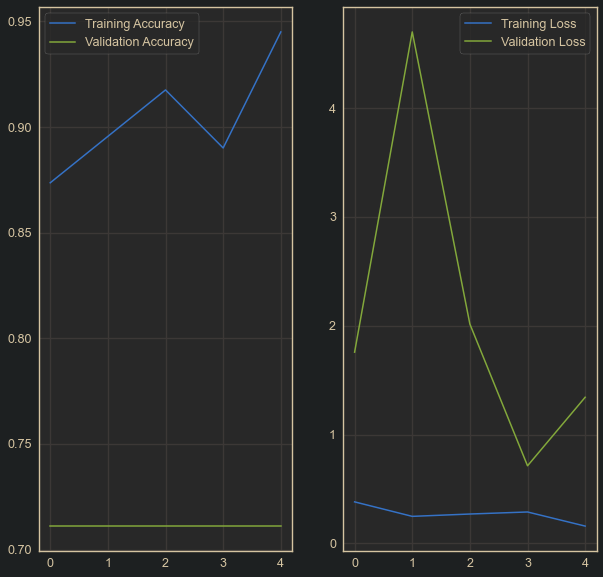

In [16]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(epochs)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,val_acc,label='Validation Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Training Loss')
plt.plot(epochs_range,val_loss,label='Validation Loss')
plt.legend()
plt.show()

In [17]:
train_label = np.concatenate([train_label for _, train_label in train], axis=0)
val_label = np.concatenate([val_label for _, val_label in validation],axis=0)
train_pred=model.predict(train).flatten()
val_pred=model.predict(validation).flatten()

In [18]:
print(sklearn.metrics.classification_report(train_label,train_pred>=0.5))
print(sklearn.metrics.classification_report(val_label,val_pred>=0.5))
sklearn.metrics.confusion_matrix(train_label,train_pred>=0.5)
sklearn.metrics.confusion_matrix(val_label,val_pred>=0.5)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        59
           1       0.67      0.99      0.80       123

    accuracy                           0.67       182
   macro avg       0.34      0.50      0.40       182
weighted avg       0.46      0.67      0.54       182

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.71      1.00      0.83        32

    accuracy                           0.71        45
   macro avg       0.36      0.50      0.42        45
weighted avg       0.51      0.71      0.59        45



C:\Users\R3M0\anaconda3\envs\38tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\R3M0\anaconda3\envs\38tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\R3M0\anaconda3\envs\38tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[ 0, 13],
       [ 0, 32]], dtype=int64)

In [30]:
#Understand the filters in the model 
#Let us pick the first hidden layer as the layer of interest.
layer = model.layers #Conv layers at 2, 5, 9
filters, biases = model.layers[9].get_weights()
print(layer[9].name, filters.shape)

conv2d_2 (5, 5, 32, 64)


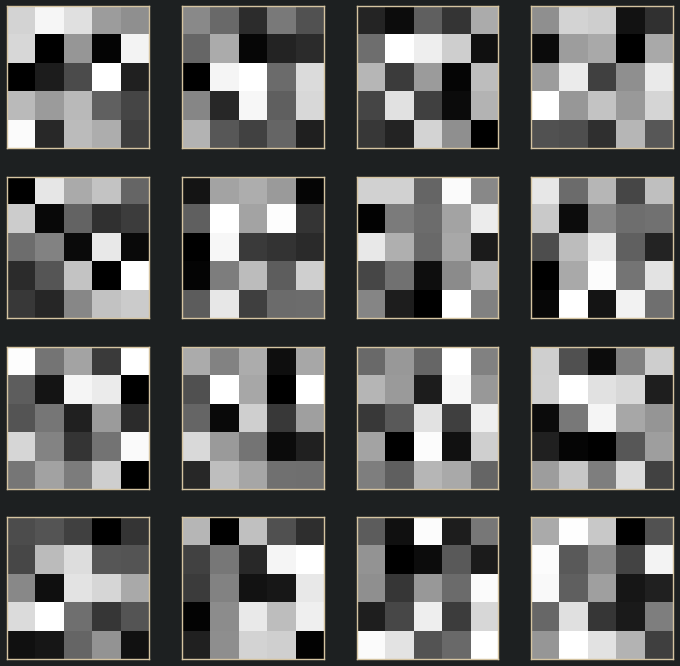

In [22]:
# plot filters
fig1=plt.figure(figsize=(12, 12))
columns = 4
rows = 4
n_filters = columns * rows
for i in range(1, n_filters +1):
    f = filters[:, :, :, i-1]
    fig1 =plt.subplot(rows, columns, i)
    fig1.set_xticks([])  #Turn off axis
    fig1.set_yticks([])
    plt.imshow(f[:, :, 0], cmap='gray') #Show only the filters from 0th channel (R)
    #ix += 1
plt.show()    

In [24]:
#### Now plot filter outputs    

#Define a new truncated model to only include the conv layers of interest
#conv_layer_index = [1, 3, 6, 8, 11, 13, 15]
conv_layer_index = [2, 5, 9]  #TO define a shorter model
outputs = [model.layers[i].output for i in conv_layer_index]
model_short = tf.keras.models.Model(inputs=model.inputs, outputs=outputs)
print(model_short.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_input (InputLayer) [(None, 1080, 1080, 3)]   0         
_________________________________________________________________
rescaling (Rescaling)        (None, 1080, 1080, 3)     0         
_________________________________________________________________
sequential (Sequential)      (None, 1080, 1080, 3)     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 268, 268, 16)      6928      
_________________________________________________________________
batch_normalization (BatchNo (None, 268, 268, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 134, 134, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 65, 65, 32)        12832 

In [25]:
#Input shape to the model is 224 x 224. SO resize input image to this shape.
from keras.preprocessing.image import load_img, img_to_array
img = load_img('C:/Users/R3M0/Documents/Project KLE-BGM/Models/SN/0/aug879.jpg', target_size=img_size)

In [26]:
# convert the image to an array
img = img_to_array(img)
# expand dimensions to match the shape of model input
img = np.expand_dims(img, axis=0)

In [27]:
# Generate feature output by predicting on the input image
feature_output = model_short.predict(img)

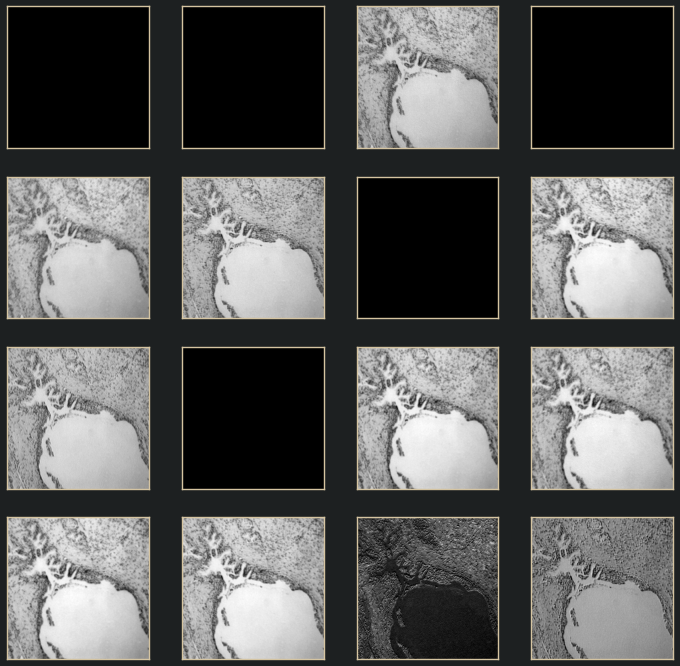

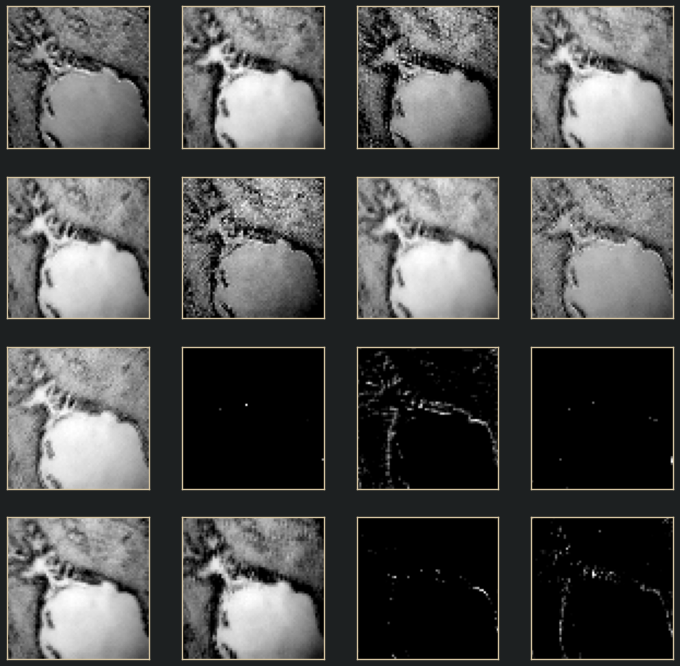

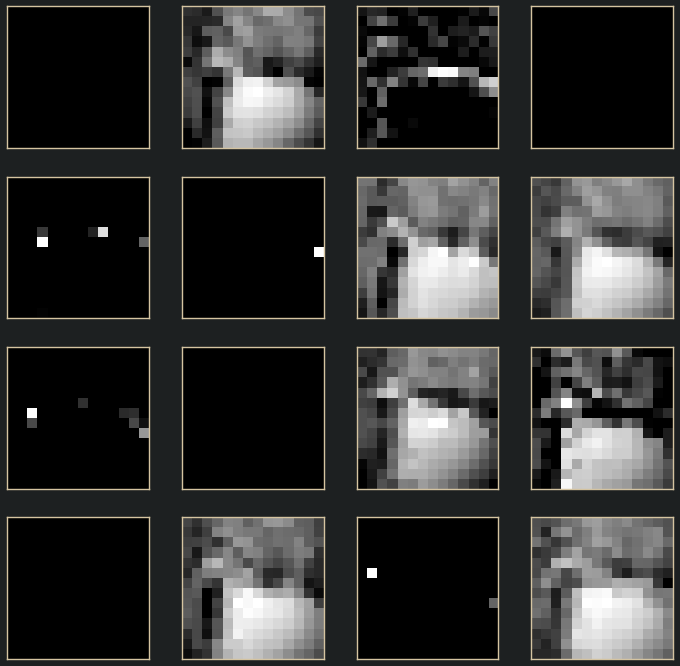

In [29]:
columns = 4
rows = 4
for ftr in feature_output:
    #pos = 1
    fig=plt.figure(figsize=(12, 12))
    for i in range(1, columns*rows +1):
        fig =plt.subplot(rows, columns, i)
        fig.set_xticks([])  #Turn off axis
        fig.set_yticks([])
        plt.imshow(ftr[0, :, :, i-1], cmap='gray')
        #pos += 1
    plt.show()